In [110]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

In [111]:
b = next(iter(loader))

with torch.no_grad():
    model.eval()
    model.coord_tensor = None
    mid_res, _ = mid_getter(b['image'], b['question'])

In [147]:
b['question'][0]

tensor([ 1,  2, 47, 21, 70, 31, 48, 17, 18, 26, 20, 17,  4, 41, 24, 12,  0])

In [119]:
%matplotlib inline

In [116]:
f_activations = torch.stack([mid_res[f'identity_fc{i}'] for i in range(1, 3)], dim=1)

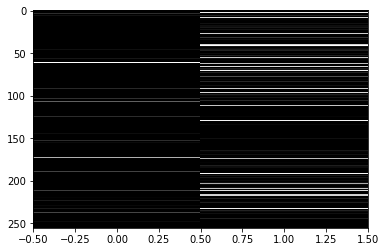

In [120]:
norm_activations = f_activations[0].t() * ((1 / f_activations[0].max(dim=1).values))
plt.imshow(norm_activations.detach().numpy(), aspect='auto', cmap='Greys_r')

In [144]:
g_activations = torch.stack([mid_res[f'identity_gc{i}'].view(-1, 64 * 64 * 256) for i in range(0, 4)], dim=1)

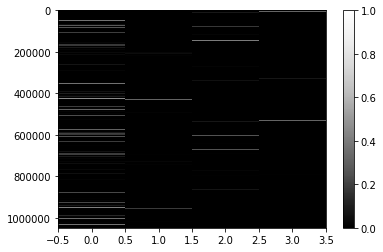

In [145]:
norm_activations_g = g_activations[0].t() * ((1 / g_activations[0].max(dim=1).values))
plt.imshow(norm_activations_g.detach().numpy(), aspect='auto', cmap='Greys_r')
plt.colorbar()

In [146]:
(g_activations[0] == 0).sum(dim=1)

tensor([ 782359,  943729,  982908, 1036209])

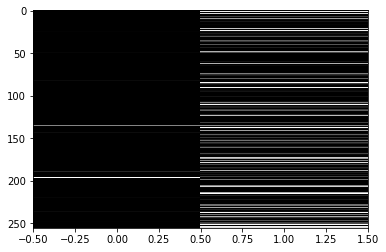

In [121]:
norm_activations2 = f_activations[1].t() * ((1 / f_activations[1].max(dim=1).values))
plt.imshow(norm_activations2.detach().numpy(), aspect='auto', cmap='Greys_r')

In [46]:
X_embedded = TSNE(n_components=2).fit_transform(torch.cat([all_res[qtype]['mha_gc1'] for qtype in qtypes]))

In [36]:
X_embedded

array([[ 153.93373 ,  129.25932 ],
       [ 207.70412 ,  -33.28526 ],
       [ -17.270176,  128.3473  ],
       [ -69.30714 ,  -34.757526],
       [  68.95953 ,   10.983522],
       [  69.73261 , -134.65114 ]], dtype=float32)

In [56]:
%matplotlib notebook

In [58]:
from matplotlib.cm import get_cmap

tab20 = get_cmap('tab20').colors

<IPython.core.display.Javascript object>


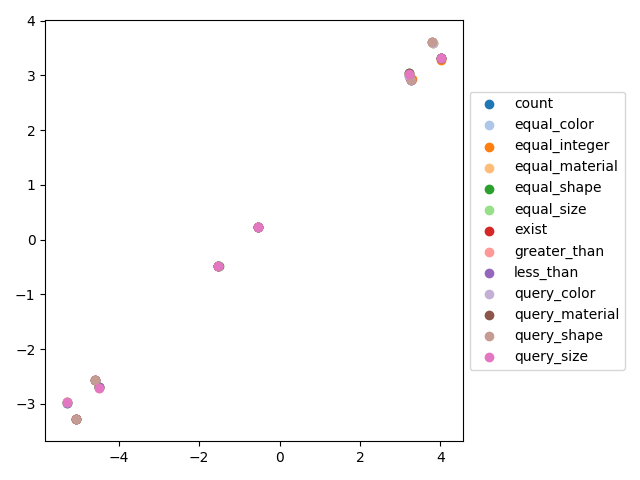

In [65]:
for i, qtype in enumerate(qtypes):
    plt.scatter(
        X_embedded[i * 6:(i + 1) * 6, 0], X_embedded[i * 6:(i + 1) * 6, 1],
        c=[tab20[i]],
        label=qtype,
    )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle

import torch

import numpy as np

from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt

from attrdict import AttrDict

from model import RN
from viz_utils import init_selected_datasets, load_model, compute_mid_results, get_all_metrics, mha_keys, identity_keys, plot_masks_per_qtype, plot_masks_histograms


device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [3]:
print(torch.cuda.device_count())
device

0


'cpu'

In [4]:
selected_ds_per_qtype, dictionaries = init_selected_datasets(
    # '/mnt/nas2/GrimaRepo/datasets/CLEVR_v1.0',
    '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/',
    # '/home/fcorencoret/RelationNetworks-CLEVR/questions/CLEVR_built_dictionaries.pkl',
    'viz/CLEVR_built_dictionaries.pkl',
    'viz/selected_idxs_per_qtype.json',
)

with open('config.json', 'r') as f:
    hyp = json.load(f)['hyperparams']['original-fp']
    
qtypes = list(selected_ds_per_qtype.keys())

args = AttrDict()
args.qdict_size = len(dictionaries[0])
args.adict_size = len(dictionaries[1])

==> using cached questions: questions/CLEVR_val_questions.pkl


In [19]:
model = load_model(
    RN(args, hyp),
    # '/mnt/nas2/GrimaRepo/jahurtado/codes/dynamic-rn/Norm_learn_reg_sb_0.1/best_weights.pth',
    [device],
)

Supposing original DeepMind model


In [96]:
res = compute_mid_results(
    model,
    selected_ds_per_qtype,
    bsz=128,
    device=device,
    samples_per_qtype=16,
    with_identity=True,
    with_attention=True,
)

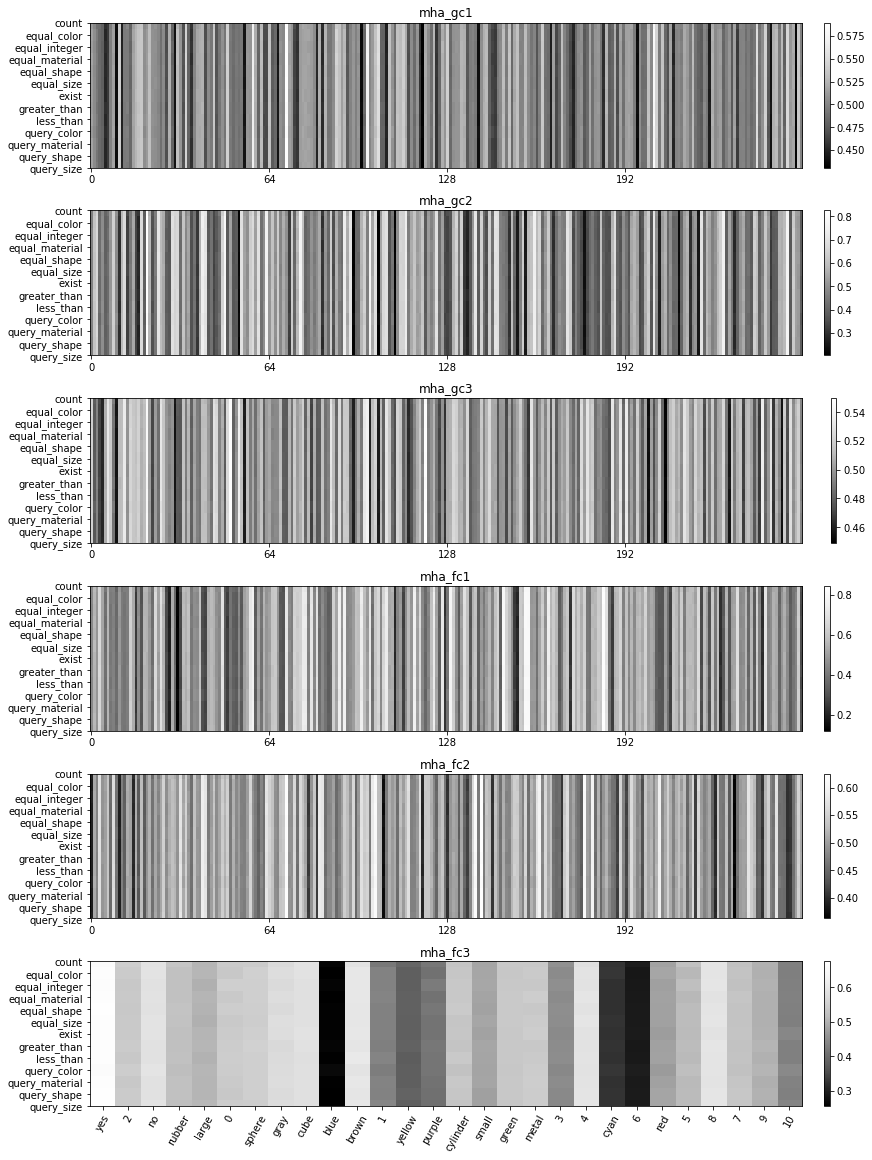

In [98]:
fig, axes = plot_masks_per_qtype(res, adict=dictionaries[1])

In [99]:
metrics = get_all_metrics(res)

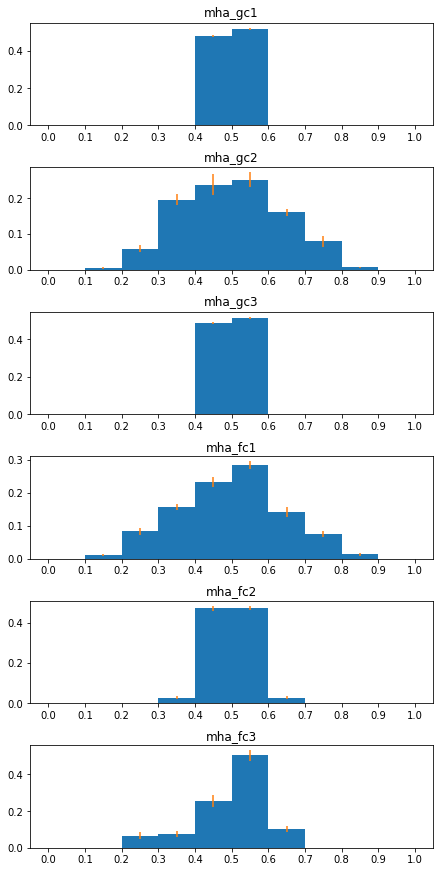

(<Figure size 432x864 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x17735cb10>,
       dtype=object))

In [100]:
plot_masks_histograms(metrics['agg_metrics'])

In [120]:
ssz = metrics['agg_metrics'][identity_keys[0]]['sparsity'].size(0)

sparsity_histograms = {
    identity_name: _get_mask_metrics(metrics['agg_metrics'][identity_name]['sparsity'].view(ssz, -1))
    for identity_name in identity_keys
}

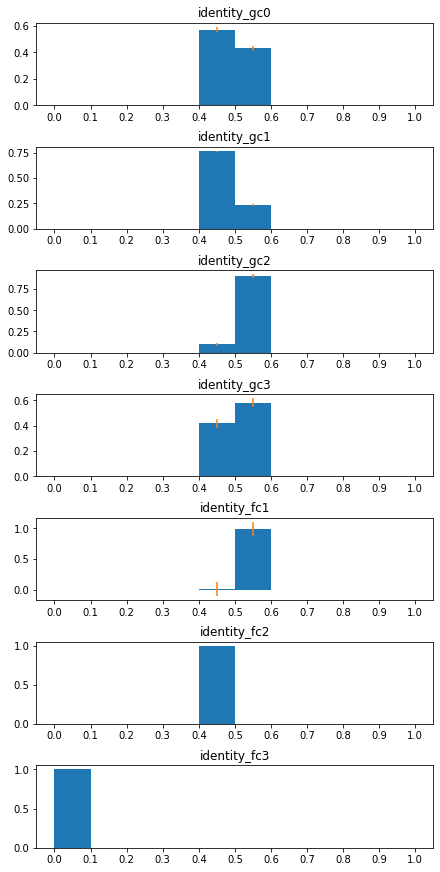

(<Figure size 432x864 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x148f327d0>,
       dtype=object))

In [121]:
plot_masks_histograms(sparsity_histograms, keys=identity_keys)